<h1><center>Hiden Markov Model</center></h1>
This is a notebook with the implementation of HMM in python with some basic analisys and visualizations to test its quality.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import dirichlet
import seaborn as sns
from collections import defaultdict
plt.style.use('../../style/site_style.mplstyle')

class HMM(object):
    '''
    Implements the hidden markov model

    Parameters:
        iters: Number of iterations
        n_states: number of possible states
        n_obs: Number of possible observations
        precision: Precision threshhold to be achieved during training
        

    Methods:
        fit: Fit the HMM to a give observation sequence
            INPUT:
                observations: Array with the observation sequence
        initialize: Method to initialize the model paramenters. If no initial values are provided,
            then the initialization is random based on a Dirichlet distribution
            INPUT:
                T: Time duration
                A: State transition matrix
                B: Observation matrix
                pi: Initial state distribution
                
        alpha_pass: Peforms a forward alpha pass, evaluationg all alphas and scaling then
        
        beta_pass: Calculates beta parameters and scaling then. As the scaling parameters
            are calculated in the alpha pass, this method must no be called without first calling an alpha pass
        
        estimate_gammas: Calculates both gammas and di-gammas based on the alpha and beta values.
        
        reestimate: Re estimates the model
        
        log_ods: Returns P(observations | model) with the current parameters
        
        generate_seqience: Generates a sequence of observations and states with the current paramenters.
            OUTPUTS:
                observations: array of size T with the sequence of observations.
                states: array of size T with the sequence of states
        
        Fields: The hmm has the following public fileds (except those defined in initialization)

        A: State matrix
        B: Observations matrix
        pi: Initial state distribuition
        alphas: ALpha parameters
        betas: Beta paramenters
        gammas: Gammas
        digammas: Di - gammas
        scale: Scale factors. Used to estimate probabilities
        _historic: Precision historic during training
        
    '''
    def __init__(self, iters = 1000, n_states = 2, n_obs = 3, precision = 0.1):
        self.iters = iters
        self.n_states = n_states
        self.n_obs = n_obs
        self.precision = precision

        self.best_prob = -np.inf
        self.no_improv_steps = 0
        self.observations = []
        self.T = 0

        self.A = []
        self.B = []
        self.pi = []
        self.alphas = []
        self.betas = []
        self.gammas = []
        self.digammas = []
        self.scale = []

    def initialize(self, T, A = [], B = [], pi = []):
        self.T = T

        self.alphas = np.zeros((self.T , self.n_states))
        self.betas = np.zeros((self.T, self.n_states))
        self.gammas = np.zeros((self.T, self.n_states))
        self.digammas = np.zeros((self.T, self.n_states, self.n_states))
        self.scale = np.zeros((self.T))

        # Initialize transition matrices
        if A:
            self.A = A
        else:
            self.A = dirichlet(
                    np.ones(self.n_states) * self.n_states,
                    size = self.n_states,
                    )
        if B:
            self.B = B
        else:
            self.B = dirichlet(
                    np.ones(self.n_obs) * self.n_obs,
                    size = self.n_states,
                    )
        if pi:
            self.pi = pi
        else:
            self.pi = dirichlet(
                    np.ones(self.n_states) * self.n_states,
                    size = 1
                    )

    def alpha_pass(self):
        ## Initialization step
        self.scale[0] = 0
        for i in range(self.n_states):
            self.alphas[0][i] = self.pi[0][i] * self.B[i][self.observations[0]]
            self.scale[0] += self.alphas[0][i]
        # Scaling
        self.scale[0] = 1 / self.scale[0]
        self.alphas[0] *= self.scale[0]

        ## Foward propagation step
        for t in range(1, self.T):
            self.scale[t] = 0
            for i in range(self.n_states):
                self.alphas[t][i] = 0
                for j in range(self.n_states):
                    self.alphas[t][i] += self.alphas[t - 1][j] * self.A[j][i]
                self.alphas[t][i] *= self.B[i][self.observations[t]]
                self.scale[t] += self.alphas[t][i]

            # Scale alpha_t(i)
            self.scale[t] = 1 / self.scale[t]
            self.alphas[t] *= self.scale[t]

    def beta_pass(self):
        ## Initialization step
        for i in range(self.n_states):
            self.betas[self.T - 1][i] = 1 * self.scale[self.T - 1]

        for t in range(self.T - 2, -1, -1):
            for i in range(self.n_states):
                self.betas[t][i] = 0
                for j in range(self.n_states):
                    self.betas[t][i] += self.A[i][j] * self.B[j][self.observations[t+1]] * self.betas[t+1][j]
                self.betas[t][i] *= self.scale[t]

    def estimate_gammas(self):
        # Estimate gammas and digammas. As alphas and betas are scaled there is no need to sacle the gammas
        for t in range(self.T - 1):
            for i in range(self.n_states):
                self.gammas[t][i] = 0
                for j in range(self.n_states):
                    self.digammas[t][i][j] = self.alphas[t][i] * self.A[i][j]  * self.B[j][self.observations[t+1]] * self.betas[t+1][j]
                    self.gammas[t][i] += self.digammas[t][i][j]
        # Special case for the last element
        for i in range(self.n_states):
            self.gammas[self.T - 1][i] = self.alphas[self.T - 1][i]

    def reestimate(self):
        # Reestimate the initial state:
        for i in range(self.n_states):
            self.pi[0][i] = self.gammas[0][i]

        # Reestimate the state trasition matrix A:
        for i in range(self.n_states):
            denom = 0
            for t in range(self.T - 1):
                denom += self.gammas[t][i]

            for j in range(self.n_states):
                numer = 0
                for t in range(self.T - 1):
                    numer += self.digammas[t][i][j]
                self.A[i][j] = numer / denom
        
        # Reestimate the observation transition matrix B
        for i in range(self.n_states):
            denom = 0
            for t in range(self.T):
                denom += self.gammas[t][i]
            for j in range(self.n_obs):
                numer = 0
                for t in range(self.T):
                    if self.observations[t] == j:
                        numer += self.gammas[t][i]
                self.B[i][j] = numer / denom

    def log_ods(self):
        log_prob = 0
        for i in range(self.T):
            log_prob += np.log(self.scale[i])
        return -log_prob

    def fit(self, observations):
        self.observations = observations
        if self.n_obs < len(set(observations)):
            print(f'Invalid number of possible observations. Model has {self.n_obs} and there are {len(set(observations))} in the sequence')
        
        self._historic = []
        self.initialize(T = len(observations))

        for step in range(self.iters):
            self.alpha_pass()
            self.beta_pass()
            self.estimate_gammas()
            self.reestimate()
            prob = self.log_ods()
            self._historic.append(prob)

            if prob >= self.best_prob:
                self.best_prob = prob
            else:
                #if abs(prob - self.best_prob) < self.precision:
                break

    def generate_sequece(self):
        possible_states = list(range(len(self.A[0])))
        possible_observations = list(range(len(self.B[0])))

        states = [np.random.choice(possible_states, p = self.pi[0])]
        observations = [np.random.choice(possible_observations, p = self.B[states[0]]) ]
        for _ in range(self.T):
            states.append(np.random.choice(possible_states, p = self.A[states[-1]]))
            observations.append(np.random.choice(possible_observations, p = self.B[states[-1]]))

        return observations, states

In [2]:
def relative_distance(hmm1, hmm2, observations):
    if len(set(hmm1.scale)) < 2: # Ideally 1, but for safety 2
        hmm1.observations = observations
        hmm1.alpha_pass()
    if len(set(hmm2.scale)) < 2:
        hmm2.observations = observations
        hmm2.alpha_pass()
    return sum([np.log(c) for c in hmm2.scale]) - sum([np.log(c) for c in hmm1.scale])

In [3]:
T = 5000
A_true = [[0.7, 0.3], [0.4, 0.6]] 
B_true = [[0.1, 0.4, 0.5], [0.7, 0.2, 0.1]] 
pi_true = [[0.7, 0.3]]

hmm_true = HMM()
hmm_true.initialize(T, A_true, B_true, pi_true)
observations, states = hmm_true.generate_sequece()

hmm = HMM()
hmm.fit(observations)

hmm_random = HMM()
hmm_random.initialize(T)

In [4]:
print(f'Distance between trained and true: {relative_distance(hmm, hmm_true, observations)}')
print(f'Distance between true and random: {relative_distance(hmm_true, hmm_random, observations)}')
print(f'Distance between trained and random: {relative_distance(hmm, hmm_random, observations)}')

Distance between trained and true: 1.5076702838377969
Distance between true and random: 293.0593463040668
Distance between trained and random: 294.5670165879046


In [5]:
generated_obs , generated_states = hmm.generate_sequece()
random_obs, random_states = hmm_random.generate_sequece()

In [6]:
def visualize_observations(observations, title, max_obs = 300):
    plt.style.use('seaborn-dark-palette')
    fig, ax = plt.subplots(1, figsize = (16,3))
    
    obs_size = [10, 20, 40]
    colors = ['#fcc473', '#e78c4d','#b95939'][::-1]
    
    radius = [observations[0]]
    for obs in observations[1:max_obs]:
        radius.append(radius[-1] + obs_size[obs])
        
    for i, obs in enumerate(observations[:max_obs]):
        ax.plot([0], [0], marker = 'o', markerfacecolor = colors[obs], markersize = radius[i], markeredgecolor = '#79271c', zorder = -i)
    ax.set_xlim(right=radius[-1])
    ax.axis('off')
    plt.title(title)
    plt.show()

One interesting aspect to analyse is the patterns generated by the true model compared to patterns that can be obtainend with the trained model and a randomly initialized model.

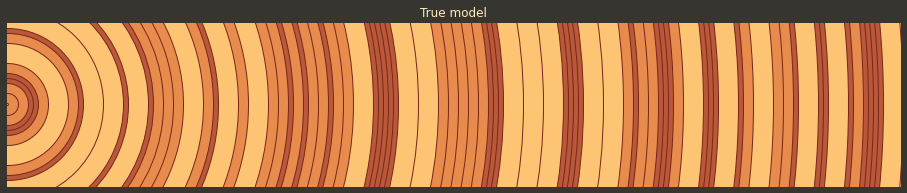

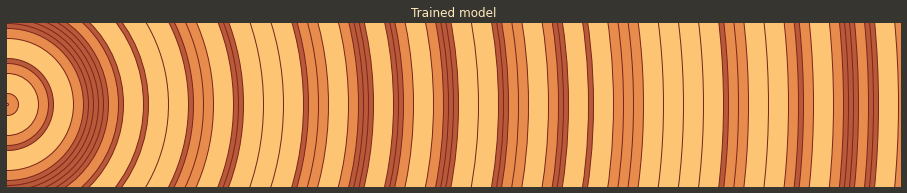

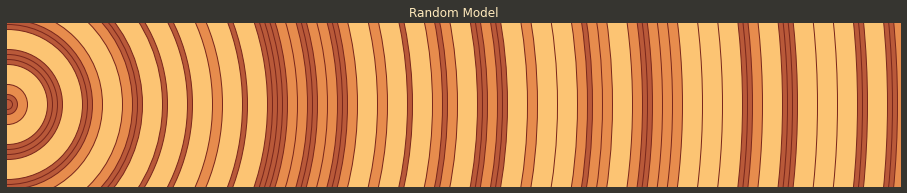

In [7]:
plt.style.use('seaborn-dark-palette')
visualize_observations(observations.copy(), 'True model')
visualize_observations(generated_obs.copy(), 'Trained model')
visualize_observations(random_obs.copy(), 'Random Model')

Anorther analysis that can be made is to study the number of each observations and the 

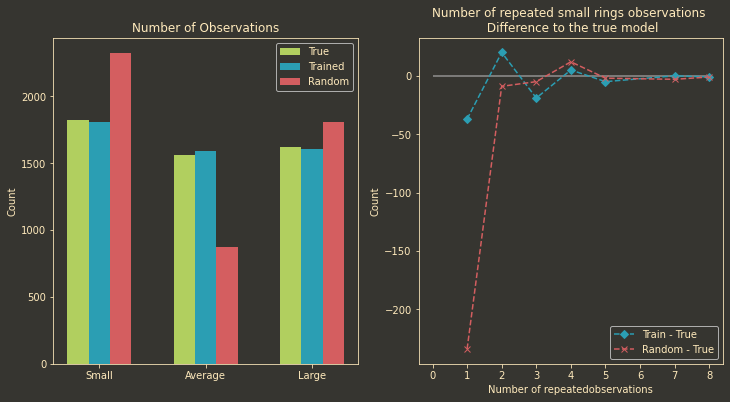

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

labels = ['Small', 'Average', 'Large']
colors = ['#B1CF5F', '#2B9EB3', '#D45E60']

# Count plot
true_unique, true_counts = np.unique(observations, return_counts = True)
train_unique, train_counts = np.unique(generated_obs, return_counts = True)
random_unique, random_counts = np.unique(random_obs, return_counts = True)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

ax[0].bar(x - width, true_counts, width, label = 'True', color = colors[0])
ax[0].bar(x , train_counts, width, label = 'Trained', color = colors[1])
ax[0].bar(x + width, random_counts, width, label = 'Random', color = colors[2])

ax[0].set_ylabel("Count")
ax[0].set_xticks(range(len(labels)))
ax[0].set_xticklabels(labels)
ax[0].legend()
ax[0].set_title(f"Number of Observations")


# Consecutive observations analysis
markers = ['o', 'D', 'x']

def count_consecutives(obs_sequence):
    '''Return the unique values of repeated values in obs_sequence, and their lengths
    INPUT:
        obs_sequence: Sequence of observations
    OUTPUT:
        unique sequence lengths
        legths of the sequences
    '''
    consecutives = defaultdict(list)
    prev_obs = obs_sequence[0]
    count = 1
    for obs in obs_sequence[1:]:
        if obs == prev_obs:
            count += 1
        else:
            consecutives[obs].append(count)
            count = 1
        prev_obs = obs
    return np.unique(consecutives[0], return_counts = True)

uniques_true, consecutives_true = count_consecutives(observations)
uniques_train, consecutives_train = count_consecutives(generated_obs)
uniques_random, consecutives_random = count_consecutives(random_obs)

uniques = [uniques_true, uniques_train, uniques_random]
consecutives = [consecutives_true, consecutives_train, consecutives_random]
largest_uniq = uniques[np.argmax([len(l) for l in uniques])]

# Fill other arrays with 0 so all have the same size
for i, l in enumerate(list(zip(uniques, consecutives))):
    uniq, consec = l
    for _ in range(len(largest_uniq) - len(uniq)):
        uniques[i] = np.append(uniques[i], 0)
        consecutives[i] = np.append(consecutives[i], 0)
        
train_diference = [(true - train) for true, train in zip(consecutives[0], consecutives[1])]
random_diference = [(true - random) for true, random in zip(consecutives[0], consecutives[2])]

ax[1].plot(
    largest_uniq,
    train_diference,
    c = colors[1],
    marker  = markers[1], 
    markerfacecolor = colors[1],
    markeredgecolor=colors[1],
    ls ='--',
    label='Train - True'
)

ax[1].plot(
    largest_uniq,
    random_diference,
    c = colors[2],
    marker  = markers[2],
    markerfacecolor = colors[2],
    markeredgecolor=colors[2],
    ls ='--',
    label='Random - True'
)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Number of repeatedobservations")
ax[1].hlines(0, 0, max(largest_uniq), lw = 2, color = 'silver', alpha = 0.5, zorder = -1)
ax[1].set_title(f"Number of repeated small rings observations \n Difference to the true model")
ax[1].legend(loc = 4)
plt.show()

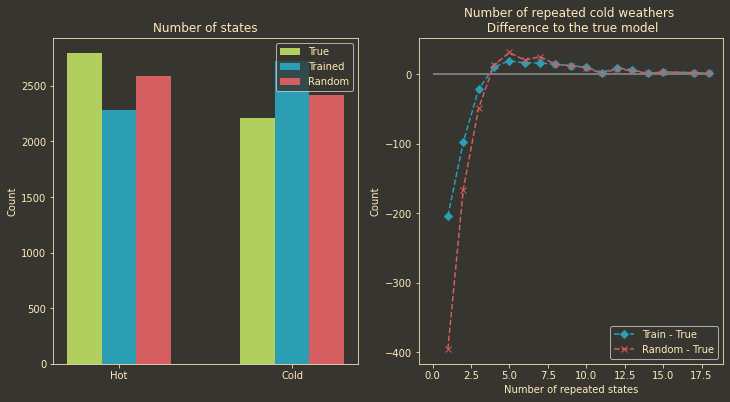

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

labels = ['Hot', 'Cold']
colors = ['#B1CF5F', '#2B9EB3', '#D45E60']

# Count plot
true_unique, true_counts = np.unique(states, return_counts = True)
train_unique, train_counts = np.unique(generated_states, return_counts = True)
random_unique, random_counts = np.unique(random_states, return_counts = True)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

ax[0].bar(x - width, true_counts, width, label = 'True', color = colors[0])
ax[0].bar(x , train_counts, width, label = 'Trained', color = colors[1])
ax[0].bar(x + width, random_counts, width, label = 'Random', color = colors[2])

ax[0].set_ylabel("Count")
ax[0].set_xticks(range(len(labels)))
ax[0].set_xticklabels(labels)
ax[0].legend()
ax[0].set_title(f"Number of states")

# Consecutive states analysis
markers = ['o', 'D', 'x']

def count_consecutives(states_sequence):
    '''Return the unique values of repeated values in states_sequence, and their lengths
    INPUT:
        states_sequence: Sequence of states
    OUTPUT:
        unique sequence lengths
        legths of the sequences
    '''
    consecutives = defaultdict(list)
    prev_states = states_sequence[0]
    count = 1
    for states in states_sequence[1:]:
        if states == prev_states:
            count += 1
        else:
            consecutives[states].append(count)
            count = 1
        prev_states = states
    return np.unique(consecutives[1], return_counts = True)

uniques_true, consecutives_true = count_consecutives(states)
uniques_train, consecutives_train = count_consecutives(generated_states)
uniques_random, consecutives_random = count_consecutives(random_states)

uniques = [uniques_true, uniques_train, uniques_random]
consecutives = [consecutives_true, consecutives_train, consecutives_random]
largest_uniq = uniques[np.argmax([len(l) for l in uniques])]

# Fill other arrays with 0 so all have the same size
for i, l in enumerate(list(zip(uniques, consecutives))):
    uniq, consec = l
    for _ in range(len(largest_uniq) - len(uniq)):
        uniques[i] = np.append(uniques[i], 0)
        consecutives[i] = np.append(consecutives[i], 0)
        
train_diference = [(true - train) for true, train in zip(consecutives[0], consecutives[1])]
random_diference = [(true - random) for true, random in zip(consecutives[0], consecutives[2])]

ax[1].plot(
    largest_uniq,
    train_diference,
    c = colors[1],
    marker  = markers[1], 
    markerfacecolor = colors[1],
    markeredgecolor=colors[1],
    ls ='--',
    label='Train - True'
)

ax[1].plot(
    largest_uniq,
    random_diference,
    c = colors[2],
    marker  = markers[2],
    markerfacecolor = colors[2],
    markeredgecolor=colors[2],
    ls ='--',
    label='Random - True'
)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Number of repeated states")
ax[1].hlines(0, 0, max(largest_uniq), lw = 2, color = 'silver', alpha = 0.5, zorder = -1)
ax[1].set_title(f"Number of repeated cold weathers \n Difference to the true model")
ax[1].legend(loc = 4)
plt.show()

The HMM model may be modified to explicitly include the duration of each state to improve peformance. Please refer to the article by Rabiner to further details on this topic.

I hope you have enjoyed this small notebook :D